In [1]:
from imports import *
from periodogram import compute_LSperiodogram
from read_data import *
from bgls import bgls
from rvmodel import get_rv1
from priors import *
from autocorrDFM import *
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# get data
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = read_HARPS()

# remove bad points known from loocv
badRVs = np.array([48])
g = np.delete(np.arange(bjd.size), badRVs)
bjd, rv, erv, fwhm, bis, Halpha, eHalpha, Hbeta, eHbeta, Hgamma, eHgamma, NaD, eNaD, Sindex, eSindex = \
bjd[g],rv[g],erv[g],fwhm[g],bis[g],Halpha[g],eHalpha[g],Hbeta[g],eHbeta[g],Hgamma[g],eHgamma[g],NaD[g],eNaD[g],Sindex[g],eSindex[g]
print bjd.size

-5678.16
113


## visualize data

<Container object of 3 artists>

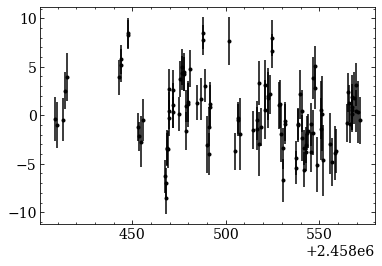

In [3]:
# plot RVs
plt.errorbar(bjd, rv, erv, fmt='k.')

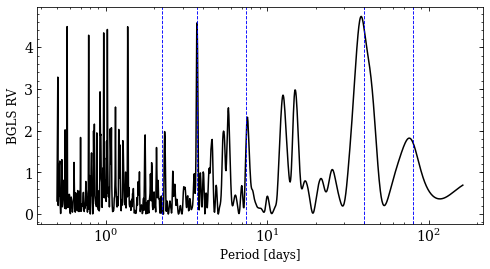

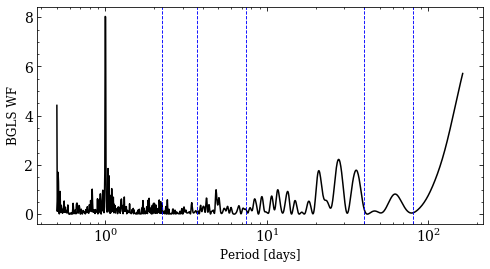

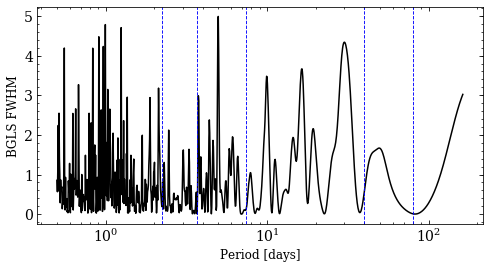

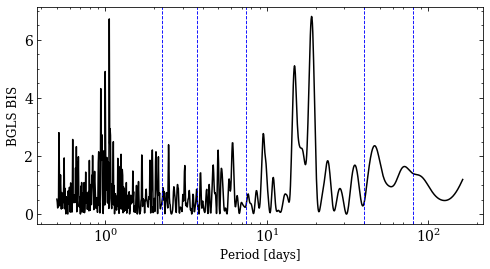

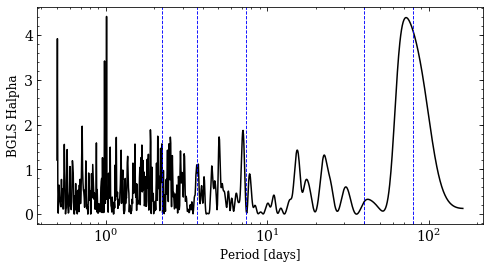

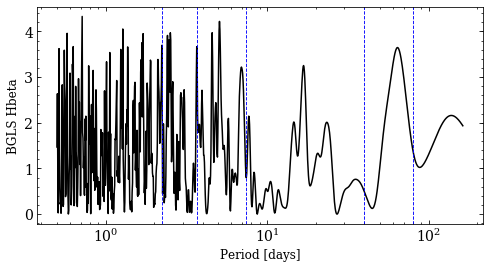

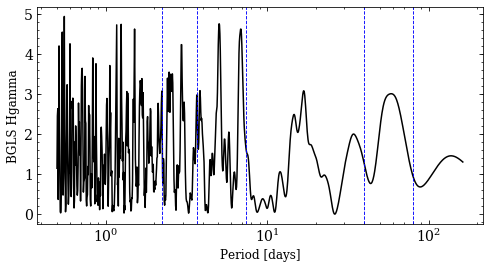

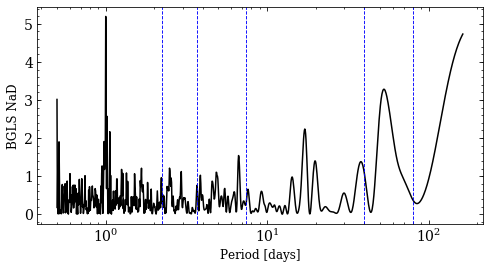

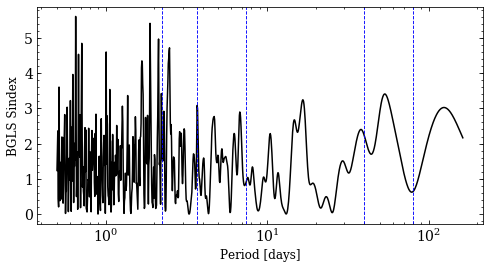

In [4]:
# plot periograms
Prot = 80
Ps = [2.25,3.69,7.45,Prot,Prot/2.]
xs = [bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd, bjd]
ys = [rv, bjd, fwhm, bis, Halpha, Hbeta, Hgamma, NaD, Sindex]
eys = [erv, erv, np.ones(bjd.size), np.ones(bjd.size), eHalpha, eHbeta, eHgamma, eNaD, eSindex]
labels = ['RV','WF','FWHM','BIS','Halpha','Hbeta','Hgamma','NaD','Sindex']
for i in range(len(xs)):
    #per,pwr = bgls(xs[i], ys[i], eys[i], plow=.5, phigh=bjd.max()-bjd.min(), n_steps=1e3)
    per,_,pwr = compute_LSperiodogram(xs[i], ys[i], eys[i], plims=(.5,bjd.max()-bjd.min()))
    plt.figure(i, figsize=(8,4))
    plt.plot(per, pwr, 'k-'), plt.xscale('log')
    plt.ylabel('BGLS %s'%labels[i], fontsize=12), plt.xlabel('Period [days]', fontsize=12)
    for p in Ps:
        plt.axvline(p, ls='--', lw=.9, color='b')

## run MCMC assuming a 1-planet model

In [5]:
def hk2ew(h, k):
    ecc = h*h + k*k
    omega = np.arctan2(k,h)
    return ecc, omega


def full_model(theta, bjd, rv, erv):
    # get params
    assert len(theta) == 11
    agp, lgp, Ggp, Pgp = np.exp(theta[:4])
    s, V, P, T0, K, h, k = theta[4:]
    # compute GPs
    kern1 = george.kernels.ExpSquaredKernel(lgp)
    kern2 = george.kernels.ExpSine2Kernel(Ggp, Pgp)
    gp = george.GP(agp*kern1*kern2)
    try:
        gp.compute(bjd, np.sqrt(erv**2+s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    # get models
    kep = get_rv1((P,T0,0,K,h,k), bjd)
    mu, cov = gp.predict(rv-V-kep, bjd)
    sig = np.sqrt(np.diag(cov))
    return gp, mu, sig, V, kep

In [6]:
def lnlike(theta, bjd, rv, erv):
    p = full_model(theta, bjd, rv, erv)
    if len(p) == 0:
        return -np.inf
    gp, mu, sig, V, kep = p
    return gp.lnlikelihood(rv-V-kep, quiet=True)

In [8]:
def lnprior(theta):
    assert len(theta) == 11
    lna,lnl,lnG,lnP,s,V,P,T0,K,h,k = theta
    lps = np.zeros(11)
    
    lps[0] = lnuniform(lna, -5, 5)
    lps[1] = lnuniform(lnl, 1, 20)
    lps[2] = lnuniform(lnG, -10, 10)
    lps[3] = lnuniform(lnP, 0, 5)
    
    lps[4] = lnjeffreysprior(s, 1e-2, 10)
    lps[5] = lnuniform(V, -3, 3)
    
    lps[6] = lngaussian(P, 3.69040, 2.5e-4) # Kostov
    lps[7] = lngaussian(T0, 2458367.2751, 6e-4)  # Kostov
    lps[8] = lnjeffreysprior(K, .1, 10)
    lps[9] = lnuniform(h, -1, 1) if hk2ew(h,k)[0] < 1 else -np.inf
    lps[10] = lnuniform(k, -1, 1) if hk2ew(h,k)[0] < 1 else -np.inf
        
    return lps.sum()

In [9]:
def lnprob(theta, bjd, rv, erv):
    lp = lnprior(theta)
    if np.isfinite(lp):
        lprob = lp + lnlike(theta, bjd, rv, erv)
        return lprob if np.isfinite(lprob) else -np.inf
    else:
        return -np.inf

In [10]:
def run_emcee(theta, bjd,rv,erv, initialize,
              nwalkers=100, burnin=200, nsteps=200, a=1.8):
    
    ndim, p0 = len(theta), []
    assert len(initialize) == ndim
    for i in range(nwalkers):
        p0.append(theta + initialize*np.random.randn(ndim))
    
    args = (bjd,rv,erv)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args, a=a)
    
    print '\nRunning Burnin...'
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burnin acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burnin took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()
    
    print 'Running MCMC...'
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print "Mean acceptance fraction: %.4f"%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes'%((time.time()-t0)/60.)
    samples = sampler.chain.reshape((-1, ndim))
    results = get_results(samples)
    
    return sampler, samples, results

In [11]:
# run mcmc
theta = np.log(2), 8, 0, np.log(40)
theta = np.append(theta, [1e-1,0])
theta = np.append(theta, [3.69040,2458367.2751,2,0,0])

initialize = 1e-1, 1e-1, 1e-1, 1e-1
initialize = np.append(initialize, [1e-2,1e-2])
initialize = np.append(initialize, [1e-4,1e-4,1e-1,1e-2,1e-2])

sampler, samples, results = run_emcee(theta, bjd,rv,erv, initialize, nwalkers=100, burnin=200, nsteps=400)


Running Burnin...


/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/priors.py:10: RuntimeWarning: invalid value encountered in log
  return np.log(pri)


Burnin acceptance fraction is 0.3105
Burnin took 3.0814 minutes

Running MCMC...
Mean acceptance fraction: 0.2309
Full MCMC took 8.8718 minutes


In [14]:
# save samples
hdu = fits.PrimaryHDU(samples)
hdu.writeto('output_data/1planet_TOI175_H113_untrainedGP_samplesv1', overwrite=True)
hdu = fits.PrimaryHDU(sampler.lnprobability)
hdu.writeto('output_data/1planet_TOI175_H113_untrainedGP_lnprobsv1', overwrite=True)

#samples = fits.open('output_data/1planet_TOI134_H111_HalphaGP_samplesv3')[0].data
#results = get_results(samples)

In [15]:
tau, Nsteps = autocorr_time_DFM(sampler.chain)
print '10 auto-correlation times = %.3f'%(tau*10)
print 'Actual length of chains = %i (i.e. %.2f auto-correlation times)'%(Nsteps,Nsteps/tau)

10 auto-correlation times = 381.604
Actual length of chains = 400 (i.e. 10.48 auto-correlation times)


## plot results

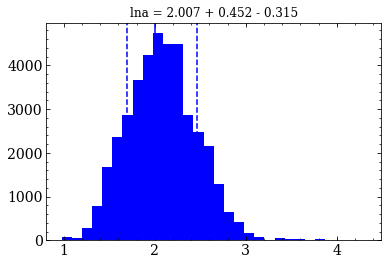

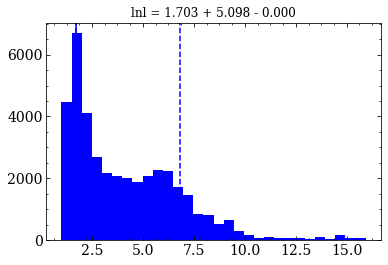

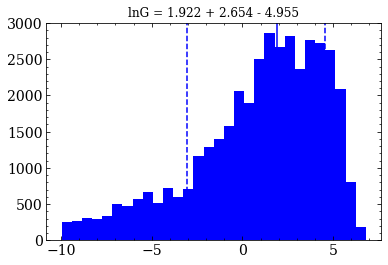

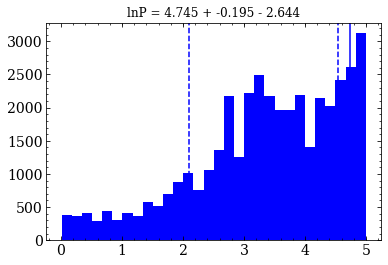

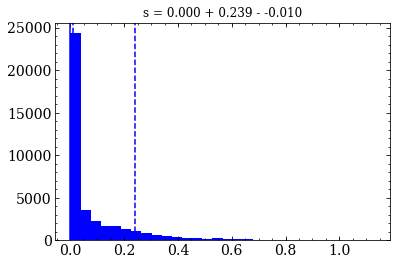

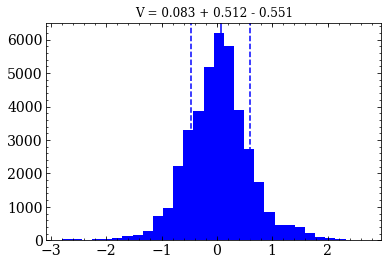

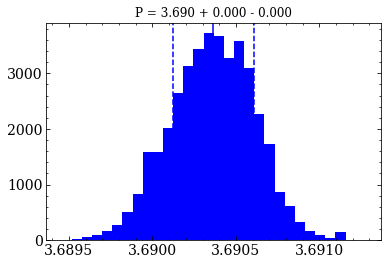

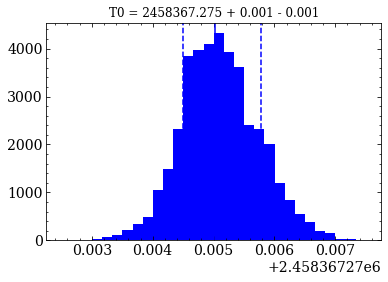

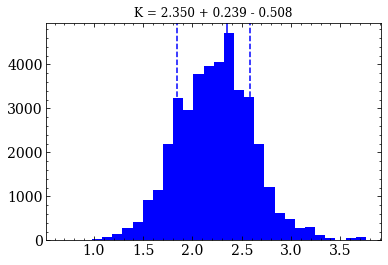

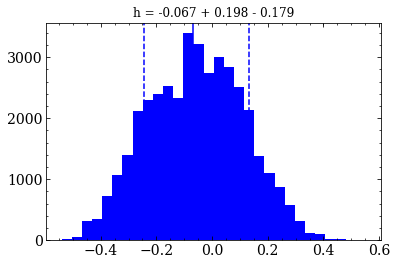

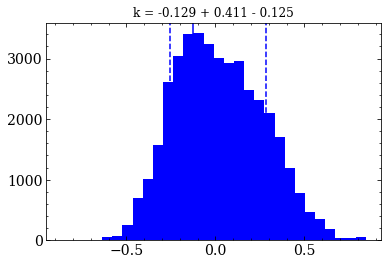

In [16]:
labels = ['lna','lnl','lnG','lnP','s','V','P','T0','K','h','k']
g = np.arange(samples.shape[0])
for i in range(samples.shape[1]):
    plt.figure(i)
    plt.hist(samples[g,i], bins=30)
    m,ps,ms = results[:,i]
    plt.axvline(m), plt.axvline(m-ms,ls='--'), plt.axvline(m+ps,ls='--')
    plt.title('%s = %.3f + %.3f - %.3f'%(labels[i],m,ps,ms))

In [17]:
# report planet parameters
Ms, Rs = unp.uarray(0.3124, 0.0032), unp.uarray(0.3137, 0.0093)   # Cloutier 2018
P1 = unp.uarray(results[0,6], results[1:,6].mean())
K1 = unp.uarray(results[0,8], results[1:,8].mean())
mp1 = rvs.RV_mp(P1, Ms, K1)
rpRs1 = unp.uarray(0.040, 2e-3)  # Kostov
rp1 = rvs.m2Rearth(rvs.Rsun2m(Rs*rpRs1))
rho1 = 5.55 * mp1 / rp1**3
print P1, K1, mp1, rp1, rho1

3.69036+/-0.00024 2.4+/-0.4 2.6+/-0.4 1.37+/-0.08 5.6+/-1.3


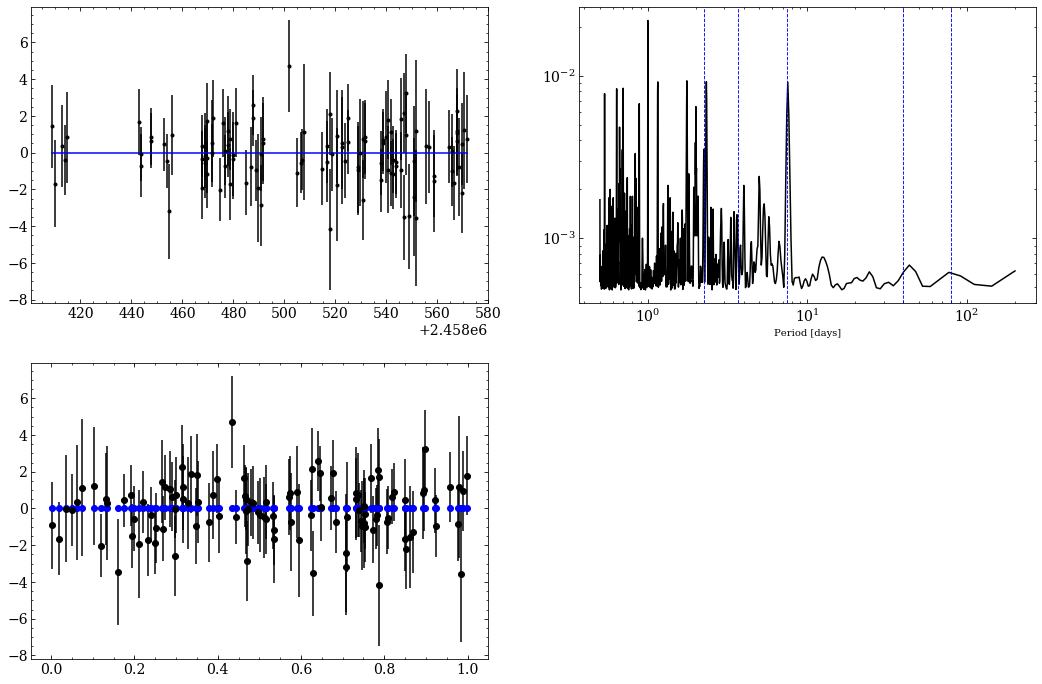

In [30]:
# plot phase-folded RVs
theta = results[0]
gp, mu, sig, V, kep = full_model(theta, bjd, rv, erv)

P,T0,K,h,k = theta[-5:]
phase = foldAt(bjd, P, T0)
xarr = bjd
yarr = rv-V-kep-mu
marr = mu*0

plt.figure(figsize=(18,12))
plt.subplot(221)
s = np.argsort(xarr)
plt.errorbar(xarr, yarr, erv, fmt='k.', capsize=0)
plt.plot(xarr[s], marr[s], 'b-')

# periodogram
per,prob = bgls(bjd, yarr, erv, plow=.5, phigh=200, n_steps=1e3)
plt.subplot(222)
plt.plot(per, prob, 'k-'), plt.xscale('log'), plt.yscale('log')
for p in Ps:
    plt.axvline(p, ls='--', lw=.9)
plt.xlabel('Period [days]')

# phase-folded
plt.subplot(223)
plt.errorbar(phase, yarr, erv, fmt='ko')
plt.plot(phase, marr, 'bo')

## run LOOCV on the remaining planet periods

In [19]:
def run_loocv(P, bjd, rv, erv, mu, kepmodel):
    '''Investigate the strength of a particular periodicity by omitting individual measurements.'''
    assert bjd.size == rv.size
    assert bjd.size == erv.size
    assert bjd.size == mu.size
    assert bjd.size == kepmodel.size
    
    prob_P = np.zeros(bjd.size)
    for i in range(bjd.size):
        # compute BGLS
        bjd_red = np.delete(bjd, i)
        rv_red = np.delete(rv-mu-kepmodel, i)
        erv_red = np.delete(erv, i)
        per,prob = bgls(bjd_red, rv_red, erv_red, plow=.5, phigh=2e2, n_steps=1e3)
        
        # what is the probability of the period of interest?
        g = np.isclose(per, P, rtol=.01)
        prob_P[i] = prob[g].max()
        
    return prob_P

In [ ]:
# run loocv
P = Ps[2]
prob_P = run_loocv(P, bjd, rv-V, erv, mu, kep2)

In [ ]:
# plot loocv results
t0 = bjd.min()
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.errorbar(bjd-t0, rv-V-mu-kep2, erv, fmt='k.')
b = (abs(prob_P-prob_P.mean()) > 3*prob_P.std())
print np.where(b)[0]
plt.plot(bjd[b]-t0, (rv-V-mu-kep2)[b], 'go', ms=10)

plt.subplot(212)
plt.plot(bjd-t0, prob_P, 'o')
plt.fill_between(bjd-t0, prob_P.mean()-prob_P.std(), prob_P.mean()+prob_P.std(), alpha=.1, color='k')
plt.fill_between(bjd-t0, prob_P.mean()-2*prob_P.std(), prob_P.mean()+2*prob_P.std(), alpha=.1, color='k')
plt.xlabel('Time of omitted measurement\n[BJD - %i]'%t0, fontsize=12)
plt.ylabel('p(%.3f days|RVs)'%P, fontsize=12)

plt.subplots_adjust(hspace=0)